# Evaluate the influence of wind speed on wind power production

In [1]:
import json
import pandas as pd
import numpy as np
import gc
from sklearn import linear_model
from sklearn.metrics import accuracy_score,r2_score
import matplotlib.pyplot as plt
import pysolar.solar as psl
from datetime import datetime, timezone, timedelta
import pytz

from influxdb import InfluxDBClient, DataFrameClient
import warnings
warnings.filterwarnings('ignore')

In [2]:
titlefont={'size':15,'weight':'bold'}
axisfont ={'size':12,'weight':'bold'}

In [3]:
config_file = "/Users/privateUser/Project/src/config.json"
with open(config_file,'r') as f:
    config = json.load(f)

connection = config['influxDB_Power']['connection']['external']
#connection = config['influxDB_Power']['connection']['internal']

clientDF = DataFrameClient(**connection)

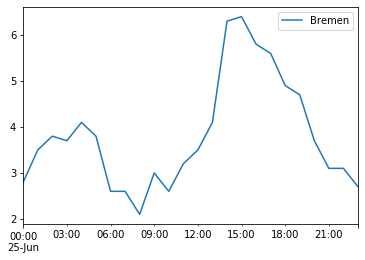

In [4]:
database = 'climate..Speed'
res = clientDF.query(f'''select "Bremen" from {database} 
                        where time >= \'2019-06-25 00:00:00\' and time < \'2019-06-26 00:00:00\'
                        ''')
windquery = res[list(res.keys())[0]]
windquery.plot()

In [5]:
res = clientDF.query(f'''show field keys from {database}''')


In [6]:
wackodot = 'Ø'
ignore = ['year','month','weekday','holiday','hour','minute',wackodot, "Fichtelberg"]
ignore

['year', 'month', 'weekday', 'holiday', 'hour', 'minute', 'Ø', 'Fichtelberg']

In [7]:
cities=[ v['fieldKey'] for v in list(res)[0] if v['fieldKey'] not in ignore]
cities

['Bremen',
 'Chemnitz',
 'Fichtelberg/Oberfranken',
 'Furstenzell',
 'Gorlitz',
 'Hamburg',
 'Hohenpeissenberg',
 'Konstanz',
 'Lindenberg',
 'Norderney',
 'Potsdam',
 'Rostock',
 'Saarbrucken',
 'Schleswig',
 'Seehausen',
 'Trier',
 'Wuerzburg']

---
# Begin productive queries
---

In [8]:
startTime = "2019-08-01 00:00:00"
#endTime   = "2019-07-01 00:00:00"
endTime = "2019-08-19 00:00:00"

In [9]:
citiesCSV = ",".join([ f'"{ct}"' for ct in cities])
queryStatement = f"""\
 SELECT {citiesCSV} FROM {database} \
                    WHERE time >= '{startTime}' \
                    AND time <= '{endTime}'"""
print(queryStatement)

 SELECT "Bremen","Chemnitz","Fichtelberg/Oberfranken","Furstenzell","Gorlitz","Hamburg","Hohenpeissenberg","Konstanz","Lindenberg","Norderney","Potsdam","Rostock","Saarbrucken","Schleswig","Seehausen","Trier","Wuerzburg" FROM climate..Speed                     WHERE time >= '2019-08-01 00:00:00'                     AND time <= '2019-08-19 00:00:00'


In [10]:
res = clientDF.query(queryStatement)
#res

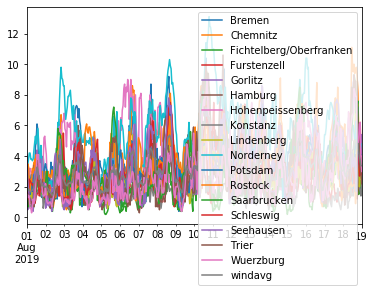

In [11]:
windMeasured = res[list(res.keys())[0]]
windMeasured.interpolate(limit_direction='both',inplace=True)
windMeasured['windavg'] = windMeasured.mean(axis=1)
windMeasured.plot(legend=True)


In [12]:
# original data for Ficthelberg was incomplete...but the good measurement has a mis-aligned name....so let's fix
old_fichtel = [ct for ct in cities if ct.startswith('Fichtel')][0]
new_ficthel = "Fichtelberg"
windMeasured.rename(columns={old_fichtel:new_ficthel},inplace=True)
cities.append(new_ficthel)
cities.remove(old_fichtel)
cities

['Bremen',
 'Chemnitz',
 'Furstenzell',
 'Gorlitz',
 'Hamburg',
 'Hohenpeissenberg',
 'Konstanz',
 'Lindenberg',
 'Norderney',
 'Potsdam',
 'Rostock',
 'Saarbrucken',
 'Schleswig',
 'Seehausen',
 'Trier',
 'Wuerzburg',
 'Fichtelberg']

---
# Query the Windyness  
- based upon city, query the locally measured wind speed
---

In [13]:
citiesCSV = ",".join([ f'currentWeather.."wc-{ct}"' for ct in cities])
queryStatement = f"""\
 SELECT "wind_speed" FROM {citiesCSV} \
                     WHERE time >= '{startTime}' \
                     AND time <= '{endTime}'"""
print(queryStatement)

 SELECT "wind_speed" FROM currentWeather.."wc-Bremen",currentWeather.."wc-Chemnitz",currentWeather.."wc-Furstenzell",currentWeather.."wc-Gorlitz",currentWeather.."wc-Hamburg",currentWeather.."wc-Hohenpeissenberg",currentWeather.."wc-Konstanz",currentWeather.."wc-Lindenberg",currentWeather.."wc-Norderney",currentWeather.."wc-Potsdam",currentWeather.."wc-Rostock",currentWeather.."wc-Saarbrucken",currentWeather.."wc-Schleswig",currentWeather.."wc-Seehausen",currentWeather.."wc-Trier",currentWeather.."wc-Wuerzburg",currentWeather.."wc-Fichtelberg"                      WHERE time >= '2019-08-01 00:00:00'                      AND time <= '2019-08-19 00:00:00'


In [14]:
#queryStatement = 'SELECT "wind_speed" FROM currentWeather.."wc-Bremen"'
res = clientDF.query(queryStatement)


In [15]:
#pd.DataFrame({'Bremen':res['wc-Bremen'].wind_speed})
res.keys()

dict_keys(['wc-Bremen', 'wc-Chemnitz', 'wc-Fichtelberg', 'wc-Furstenzell', 'wc-Gorlitz', 'wc-Hamburg', 'wc-Hohenpeissenberg', 'wc-Konstanz', 'wc-Lindenberg', 'wc-Norderney', 'wc-Potsdam', 'wc-Rostock', 'wc-Saarbrucken', 'wc-Schleswig', 'wc-Seehausen', 'wc-Trier', 'wc-Wuerzburg'])

In [16]:
windWeather = pd.DataFrame(index=windMeasured.index)
for ct in cities:
    dF = res['wc-' + ct]
    print(f"wc-{ct}: ",type(res['wc-' + ct]))
    if any(dF.get('wind_speed')):
        windWeather = windWeather.join(pd.DataFrame({ ct:dF.wind_speed}),how='outer')

wc-Bremen:  <class 'pandas.core.frame.DataFrame'>
wc-Chemnitz:  <class 'pandas.core.frame.DataFrame'>
wc-Furstenzell:  <class 'pandas.core.frame.DataFrame'>
wc-Gorlitz:  <class 'pandas.core.frame.DataFrame'>
wc-Hamburg:  <class 'pandas.core.frame.DataFrame'>
wc-Hohenpeissenberg:  <class 'pandas.core.frame.DataFrame'>
wc-Konstanz:  <class 'pandas.core.frame.DataFrame'>
wc-Lindenberg:  <class 'pandas.core.frame.DataFrame'>
wc-Norderney:  <class 'pandas.core.frame.DataFrame'>
wc-Potsdam:  <class 'pandas.core.frame.DataFrame'>
wc-Rostock:  <class 'pandas.core.frame.DataFrame'>
wc-Saarbrucken:  <class 'pandas.core.frame.DataFrame'>
wc-Schleswig:  <class 'pandas.core.frame.DataFrame'>
wc-Seehausen:  <class 'pandas.core.frame.DataFrame'>
wc-Trier:  <class 'pandas.core.frame.DataFrame'>
wc-Wuerzburg:  <class 'pandas.core.frame.DataFrame'>
wc-Fichtelberg:  <class 'pandas.core.frame.DataFrame'>


In [17]:
windWeather=windWeather.join(pd.DataFrame({'windavg':0},index=windMeasured.index),how='outer')

In [18]:
windWeather.interpolate(limit_direction='both',inplace=True)

In [19]:
windWeather = windWeather.iloc[windWeather.index.isin(windMeasured.index)]

In [20]:
windWeather['windavg'] = windWeather.mean(axis=1)

Text(0, 0.5, 'Wind Speed (m/s)')

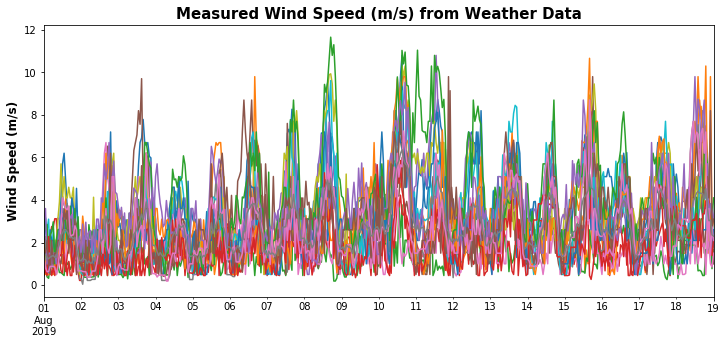

In [21]:

windWeather.plot(legend=False,figsize=(12,5))
plt.title("Measured Wind Speed (m/s) from Weather Data",fontdict=titlefont)
plt.ylabel("Wind Speed (m/s)",fontdict=axisfont)

## compare the average wind of each

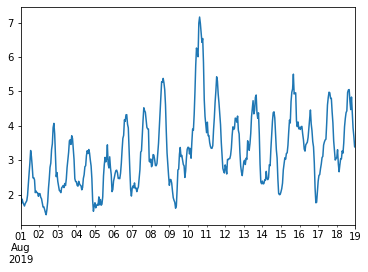

In [22]:
windMeasured.windavg.plot()

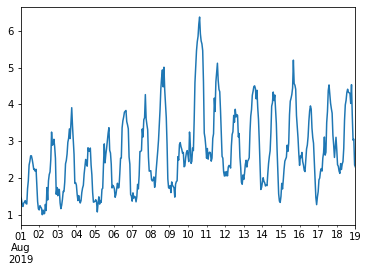

In [23]:
windWeather.windavg.plot()

Text(0, 0.5, 'Wind Speed (m/s)')

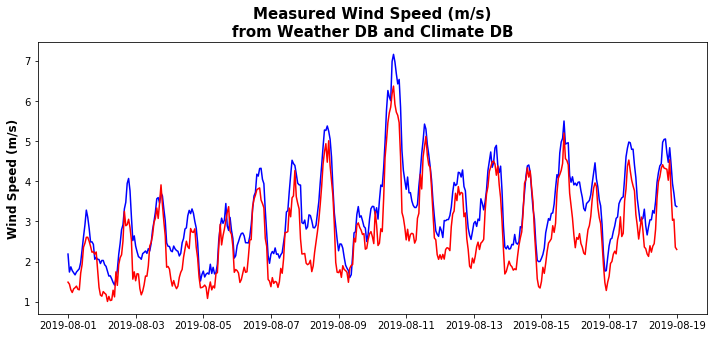

In [28]:
plt.figure(figsize=(12,5))
plt.plot(windMeasured.index,windMeasured.windavg,'b-')
plt.plot(windWeather.index,windWeather.windavg,'r-')
plt.title("Measured Wind Speed (m/s)\nfrom Weather DB and Climate DB",fontdict=titlefont)
plt.ylabel("Wind Speed (m/s)",fontdict=axisfont)

In [29]:
r2_score(windMeasured.windavg,windWeather.windavg)

0.6394760599318624

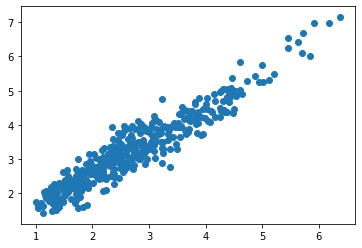

In [30]:
plt.scatter(windWeather.windavg,windMeasured.windavg)

---
# Correlate windyness with the wind power
---

---
## Regression model
---

In [31]:
reg= linear_model.LinearRegression()

In [32]:
reg.fit(X=windWeather[['windavg']],y=windMeasured.windavg)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
print(f"coefficient={reg.coef_[0]}\nintercept={reg.intercept_}")

coefficient=0.9528459015171463
intercept=0.6676592638765277


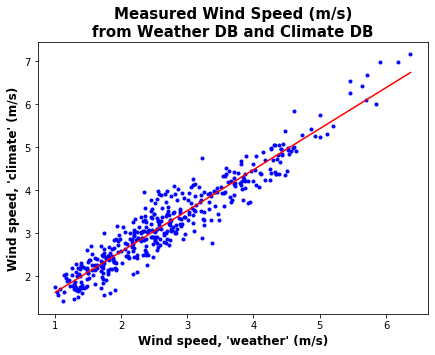

In [38]:
x = windWeather.windavg
y = windMeasured.windavg
X=np.array([x.min(),x.max()]).reshape(-1,1)
yhat=reg.predict(X)

plt.figure(figsize=(7,5))
plt.plot(x,y,'b.')
plt.plot(X,yhat,'r-')
plt.title("Measured Wind Speed (m/s)\nfrom Weather DB and Climate DB",fontdict=titlefont)
plt.xlabel("Wind speed, \'weather\' (m/s)",fontdict=axisfont)
plt.ylabel("Wind speed, \'climate\' (m/s)",fontdict=axisfont)

plt.show()

---
# Correlate wind speed with power production
---

In [39]:
database = 'power..solar_wind'

In [40]:

# select the measurements from the 'power' database for "Solar...".  Don't trust the average that they supply
res = clientDF.query(f'''show field keys from {database}''')

In [41]:
sources = [ v['fieldKey'] for v in list(res)[0] if v['fieldKey'].startswith("Wind")]
sources

['Wind Amprion',
 'Wind Transnet BW',
 'Wind offshore 50Hertz',
 'Wind offshore Tennet',
 'Wind onshore 50Hertz',
 'Wind onshore Tennet']

In [42]:
sourcesCSV = ",".join([ f'"{sr}"' for sr in sources])
queryStatement = f"""\
 SELECT {sourcesCSV} FROM {database} \
                    WHERE time >= '{startTime}' \
                    AND time <= '{endTime}'"""
print(queryStatement)

 SELECT "Wind Amprion","Wind Transnet BW","Wind offshore 50Hertz","Wind offshore Tennet","Wind onshore 50Hertz","Wind onshore Tennet" FROM power..solar_wind                     WHERE time >= '2019-08-01 00:00:00'                     AND time <= '2019-08-19 00:00:00'


In [43]:
res = clientDF.query(queryStatement)

In [44]:
windPower = res[list(res.keys())[0]]
windPower.iloc[0:10]

,Wind Amprion,Wind Transnet BW,Wind offshore 50Hertz,Wind offshore Tennet,Wind onshore 50Hertz,Wind onshore Tennet
2019-08-01 00:00:00+00:00,0.665,0.050,0.277,0.577,1.340,0.722
2019-08-01 00:15:00+00:00,0.622,0.046,0.253,0.656,1.420,0.710
2019-08-01 00:30:00+00:00,0.602,0.048,0.226,0.759,1.462,0.734
2019-08-01 00:45:00+00:00,0.590,0.047,0.216,0.847,1.409,0.772
2019-08-01 01:00:00+00:00,0.570,0.041,0.208,0.969,1.332,0.809
2019-08-01 01:15:00+00:00,0.542,0.034,0.223,1.044,1.279,0.852
2019-08-01 01:30:00+00:00,0.544,0.031,0.224,1.085,1.234,0.895
2019-08-01 01:45:00+00:00,0.552,0.026,0.227,1.137,1.190,0.910
2019-08-01 02:00:00+00:00,0.587,0.022,0.232,1.177,1.001,0.935
2019-08-01 02:15:00+00:00,0.631,0.021,0.195,1.274,0.926,0.957


In [45]:
qcols = windPower.columns

In [63]:
windPower['Wind_total'] = windPower[list(qcols)].sum(axis=1)
windPower.iloc[0:10]

,Wind Amprion,Wind Transnet BW,Wind offshore 50Hertz,Wind offshore Tennet,Wind onshore 50Hertz,Wind onshore Tennet,Wind_total
2019-08-01 00:00:00+00:00,0.665,0.050,0.277,0.577,1.340,0.722,3.631
2019-08-01 00:15:00+00:00,0.622,0.046,0.253,0.656,1.420,0.710,3.707
2019-08-01 00:30:00+00:00,0.602,0.048,0.226,0.759,1.462,0.734,3.831
2019-08-01 00:45:00+00:00,0.590,0.047,0.216,0.847,1.409,0.772,3.881
2019-08-01 01:00:00+00:00,0.570,0.041,0.208,0.969,1.332,0.809,3.929
2019-08-01 01:15:00+00:00,0.542,0.034,0.223,1.044,1.279,0.852,3.974
2019-08-01 01:30:00+00:00,0.544,0.031,0.224,1.085,1.234,0.895,4.013
2019-08-01 01:45:00+00:00,0.552,0.026,0.227,1.137,1.190,0.910,4.042
2019-08-01 02:00:00+00:00,0.587,0.022,0.232,1.177,1.001,0.935,3.954
2019-08-01 02:15:00+00:00,0.631,0.021,0.195,1.274,0.926,0.957,4.004


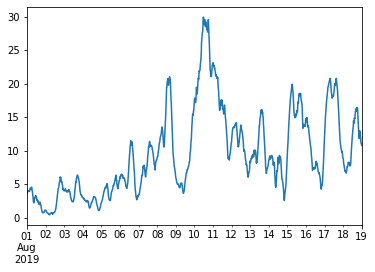

In [64]:
windPower.Wind_total.plot()

In [65]:
windWeatherWindPower = pd.DataFrame({"wind_power":windPower.Wind_total})
windWeatherWindPower.iloc[:10]

,wind_power
2019-08-01 00:00:00+00:00,3.631
2019-08-01 00:15:00+00:00,3.707
2019-08-01 00:30:00+00:00,3.831
2019-08-01 00:45:00+00:00,3.881
2019-08-01 01:00:00+00:00,3.929
2019-08-01 01:15:00+00:00,3.974
2019-08-01 01:30:00+00:00,4.013
2019-08-01 01:45:00+00:00,4.042
2019-08-01 02:00:00+00:00,3.954
2019-08-01 02:15:00+00:00,4.004


In [66]:
#citiesCSV = ",".join([ f'currentWeather.."wc-{ct}"' for ct in cities])
#queryStatement = f"""\
# SELECT "clouds" FROM {citiesCSV} \
#                    WHERE time >= '{startTime}' \
#                    AND time <= '{endTime}'"""
##print(queryStatement)
#res = clientDF.query(queryStatement)
#
#cloudsbase = pd.DataFrame()
#for ct in cities:
#    cloudsbase = cloudsbase.join(pd.DataFrame({ ct:res['wc-' + ct].clouds}),how='outer')
#    
#cloudsall= cloudsbase.interpolate(limit_direction='both').reindex(radall.index)

In [67]:
windWeatherWindPower = windWeatherWindPower.join(windWeather.windavg,how='outer').interpolate(limit_direction='both')

In [68]:
windWeatherWindPower = windWeatherWindPower.join(windMeasured.windavg,how='outer',rsuffix='_meas').interpolate(limit_direction='both')

In [69]:
windWeatherWindPower.iloc[:10]

,wind_power,windavg,windavg_meas
2019-08-01 00:00:00+00:00,3.631,1.489444,2.188235
2019-08-01 00:15:00+00:00,3.707,1.477128,2.076471
2019-08-01 00:30:00+00:00,3.831,1.464812,1.964706
2019-08-01 00:45:00+00:00,3.881,1.452495,1.852941
2019-08-01 01:00:00+00:00,3.929,1.440179,1.741176
2019-08-01 01:15:00+00:00,3.974,1.404886,1.773529
2019-08-01 01:30:00+00:00,4.013,1.369593,1.805882
2019-08-01 01:45:00+00:00,4.042,1.334301,1.838235
2019-08-01 02:00:00+00:00,3.954,1.299008,1.870588
2019-08-01 02:15:00+00:00,4.004,1.282328,1.847059


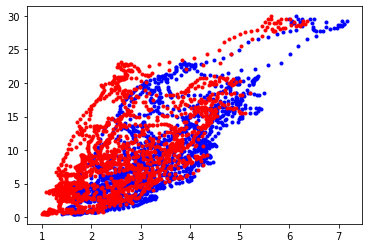

In [70]:
# explanation:  

plt.plot(windWeatherWindPower.windavg_meas,windWeatherWindPower.wind_power,'b.')
plt.plot(windWeatherWindPower.windavg,windWeatherWindPower.wind_power,'r.')
plt.show()

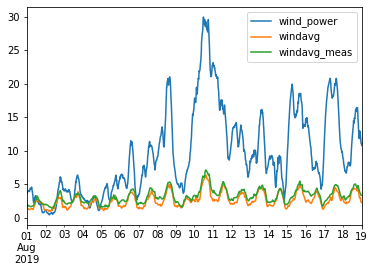

In [71]:
# conversly, predicted radiative flux is an approximate value for the solar power produced
windWeatherWindPower.plot()

In [72]:
col= (qcol for qcol in list(qcols))

In [73]:
def norm(x): 
    xnew = (x - x.min())/(x.max()-x.min())
    return xnew

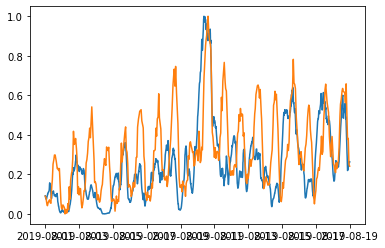

In [74]:
plt.plot(windPower.index,norm(windPower[next(col)]))
plt.plot(windWeatherWindPower.index,norm(windWeatherWindPower.windavg))
plt.show()

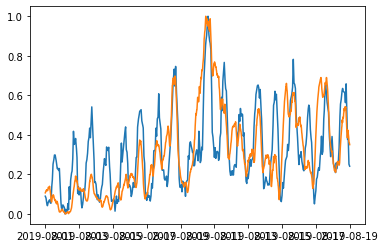

In [75]:
plt.plot(windWeatherWindPower.index,norm(windWeatherWindPower.windavg))
plt.plot(windWeatherWindPower.index,norm(windWeatherWindPower.wind_power))

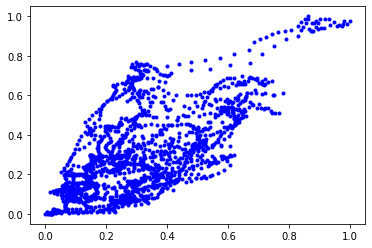

In [76]:
plt.plot(norm(windWeatherWindPower.windavg),norm(windWeatherWindPower.wind_power),'b.')
plt.show()

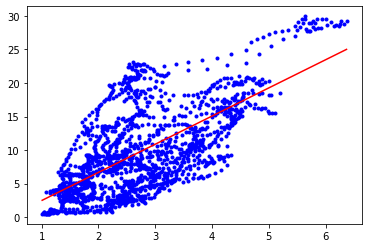

In [82]:
reg= linear_model.LinearRegression()
reg.fit(X=windWeatherWindPower[['windavg']],y=windWeatherWindPower.wind_power)
#reg.fit(X=windWeatherWindPower[qcols],y=windWeatherWindPower.wind_power)

x = windWeatherWindPower.windavg
y = windWeatherWindPower.wind_power
X=np.array([x.min(),x.max()]).reshape(-1,1)
yhat=reg.predict(X)

plt.plot(x,y,'b.')
plt.plot(X,yhat,'r-')
plt.show()

In [83]:
windWeatherWindPower['wind_power_pred'] = reg.predict(np.array(windWeatherWindPower.windavg).reshape(-1,1))

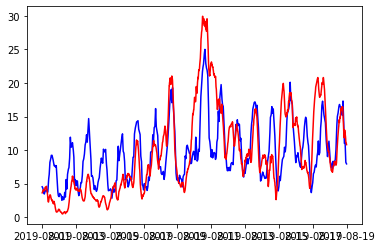

In [84]:
plt.plot(windWeatherWindPower.index,windWeatherWindPower.wind_power_pred,'b-')
plt.plot(windWeatherWindPower.index,windWeatherWindPower.wind_power,'r-')
plt.show()

In [85]:
windcols = windMeasured.columns.drop('windavg')

In [86]:
# an attempt with all wind measurements
windAllPower = pd.DataFrame({'wind_power': windWeatherWindPower.wind_power})
windAllPower = windAllPower.join(windMeasured[windcols],how='outer').interpolate(limit_direction='both')
windAllPower = windAllPower[windAllPower.index.isin(windPower.index)]
windAllPower.iloc[0:10]

,wind_power,Bremen,Chemnitz,Fichtelberg,Furstenzell,Gorlitz,Hamburg,Hohenpeissenberg,Konstanz,Lindenberg,Norderney,Potsdam,Rostock,Saarbrucken,Schleswig,Seehausen,Trier,Wuerzburg
2019-08-01 00:00:00+00:00,3.631,2.000,3.600,1.200,1.100,1.900,1.300,1.500,2.500,1.600,4.00,2.800,3.100,2.200,1.700,4.100,1.30,1.300
2019-08-01 00:15:00+00:00,3.707,1.675,3.375,1.075,1.075,1.550,1.175,1.625,2.375,1.725,3.85,2.750,3.200,1.825,1.650,3.675,1.35,1.350
2019-08-01 00:30:00+00:00,3.831,1.350,3.150,0.950,1.050,1.200,1.050,1.750,2.250,1.850,3.70,2.700,3.300,1.450,1.600,3.250,1.40,1.400
2019-08-01 00:45:00+00:00,3.881,1.025,2.925,0.825,1.025,0.850,0.925,1.875,2.125,1.975,3.55,2.650,3.400,1.075,1.550,2.825,1.45,1.450
2019-08-01 01:00:00+00:00,3.929,0.700,2.700,0.700,1.000,0.500,0.800,2.000,2.000,2.100,3.40,2.600,3.500,0.700,1.500,2.400,1.50,1.500
2019-08-01 01:15:00+00:00,3.974,0.875,2.750,0.675,1.125,0.700,0.975,2.175,1.950,2.175,3.50,2.475,3.450,0.700,1.425,2.250,1.50,1.450
2019-08-01 01:30:00+00:00,4.013,1.050,2.800,0.650,1.250,0.900,1.150,2.350,1.900,2.250,3.60,2.350,3.400,0.700,1.350,2.100,1.50,1.400
2019-08-01 01:45:00+00:00,4.042,1.225,2.850,0.625,1.375,1.100,1.325,2.525,1.850,2.325,3.70,2.225,3.350,0.700,1.275,1.950,1.50,1.350
2019-08-01 02:00:00+00:00,3.954,1.400,2.900,0.600,1.500,1.300,1.500,2.700,1.800,2.400,3.80,2.100,3.300,0.700,1.200,1.800,1.50,1.300
2019-08-01 02:15:00+00:00,4.004,1.450,2.975,0.675,1.325,1.375,1.325,2.575,1.700,2.475,3.90,2.000,2.925,0.725,1.525,1.675,1.45,1.325


In [87]:
reg= linear_model.LinearRegression()

reg.fit(X=windAllPower[windcols],y=windAllPower.wind_power)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [88]:
windAllPower['wind_power_pred'] = reg.predict(windAllPower[windcols])

In [98]:
r2_score(windAllPower.wind_power,windAllPower.wind_power_pred)

0.7968884158363326

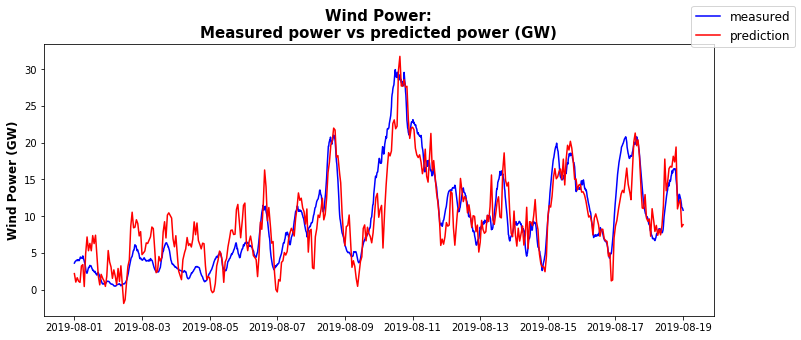

In [97]:
plt.figure(figsize=(12,5))
plt.plot(windAllPower.index,windAllPower.wind_power,'b-',label='measured')
plt.plot(windAllPower.index,windAllPower.wind_power_pred,'r-',label='prediction')
plt.title("Wind Power:\nMeasured power vs predicted power (GW)",fontdict=titlefont)
plt.ylabel("Wind Power (GW)",fontdict=axisfont)
plt.figlegend(fontsize=12)
plt.show()

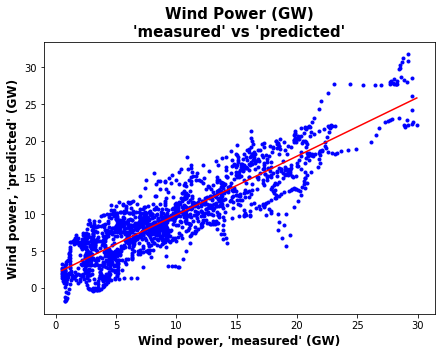

In [112]:
# plot of wind power measured vs wind power predicted
reglin = linear_model.LinearRegression()
reglin.fit(X=np.array(windAllPower.wind_power).reshape(-1,1),
           y=np.array(windAllPower.wind_power_pred).reshape(-1,1))
x_pred = np.array([windAllPower.wind_power.min(),windAllPower.wind_power.max()]).reshape(-1,1)
y_pred = reglin.predict(x_pred)

plt.figure(figsize=(7,5))
plt.plot(windAllPower.wind_power,windAllPower.wind_power_pred,'b.')
plt.plot(x_pred,y_pred,'r-')
plt.title("Wind Power (GW)\n\'measured\' vs \'predicted\'",fontdict=titlefont)
plt.xlabel("Wind power, \'measured\' (GW)",fontdict=axisfont)
plt.ylabel("Wind power, \'predicted\' (GW)",fontdict=axisfont)

plt.show()

In [79]:
#clientDF.query('CREATE DATABASE SolarWindEnergy')

ResultSet({})

In [80]:
#clientDF.write_points(dataframe=windAllPower,
#                      database='SolarWindEnergy',measurement='wind')

True

In [93]:
windcols

Index(['Bremen', 'Chemnitz', 'Fichtelberg', 'Furstenzell', 'Gorlitz',
       'Hamburg', 'Hohenpeissenberg', 'Konstanz', 'Lindenberg', 'Norderney',
       'Potsdam', 'Rostock', 'Saarbrucken', 'Schleswig', 'Seehausen', 'Trier',
       'Wuerzburg'],
      dtype='object')